In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from scipy.stats import beta
from scipy.optimize import fmin

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

c:\Users\diamo\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some parts of the below code inspired from 
https://www.kaggle.com/code/cdeotte/nn-starter-lb-72300-cv-72800

In [3]:
def cleanse_data(train, test):

    test['price'] = 0
    train['price'] = np.log(train['price'])
    train_len = len(train)
    train = pd.concat((train, test), axis=0, ignore_index=True)

    numerical_features = ['milage']
    categorical_features = [i for i in train.columns if i not in numerical_features and not i == 'price']

    # Standardize numerical features
    for i in numerical_features:
        train[i] = np.log(train[i])
        mean_val = train[i].mean()
        std_val = train[i].std()
        train[i] = train[i].apply(lambda x: (x-mean_val)/std_val)
        train[i] = train[i].fillna(mean_val)
    # train['milage'] = (train['milage']-min(train['milage']))/(max(train['milage'])-min(train['milage']))
    # a, b = beta.fit(train['milage'])


    for i in categorical_features:
        
        train[i].fillna('None')

        avg_price_by_model = train.groupby('model')['price'].mean()

        # Create a new column with the encoded values
        train['model'] = train['model'].map(avg_price_by_model)

        # If there are any models in the test set that weren't in the training set,
        # you might want to fill those with the overall average price
        # overall_avg_price = train['price'].mean()
        # train['model'].fillna(overall_avg_price, inplace=True)
        
        # # Calculate the average price for each model
        # avg_price = train.groupby(i)['price'].mean()

        # # Sort models by average price
        # sorted_models = avg_price.sort_values().index

        # # Create a mapping from model to label
        # model_to_label = {model: label for label, model in enumerate(sorted_models)}

        # # Label encode the 'model' column
        # train[i] = train[i].map(model_to_label)
    
    test = train[train_len:]
    train = train[:train_len]

    return train, test

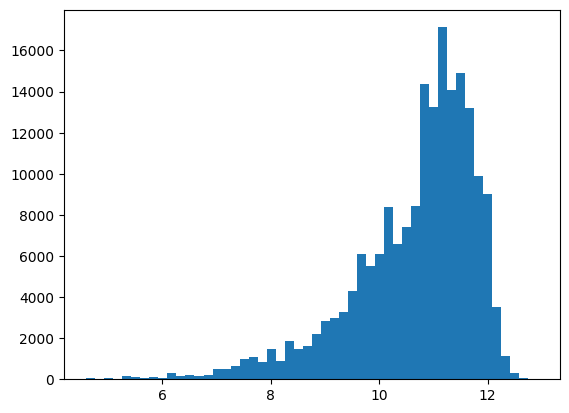

In [60]:
plt.hist(np.log(train['milage']), bins=50)
plt.show()

In [4]:
# kf = KFold(n_splits=5, random_state=42, shuffle=True)

# for i, (train_index, test_index) in enumerate(kf.split(train)):
#     print("Fold: ", i+1)
#     print("Train index: ", train_index)
#     print("Test index: ", test_index)

train_data, test_data = cleanse_data(train, test)

test_id = test['id']

# print(train_data.head())
# print(test_data.head())

train_data = TabularDataset(train_data.drop(columns='id'))
test_data = TabularDataset(test_data.drop(columns='id'))

In [6]:
# from autogluon.tabular import TabularDataset, TabularPredictor

# # test_id = test_data['id']

# if type(train_data) is not TabularDataset:
#     train_data = TabularDataset(train_data.drop(columns='id'))
#     test_data = TabularDataset(test_data.drop(columns='id'))
    
# TRAIN_LN = int(0.8*len(train_data))
# valid_data = train_data[TRAIN_LN:]
# train_data = train_data[:TRAIN_LN]

from sklearn.metrics import root_mean_squared_error

kfold = KFold(n_splits=5, shuffle=True, random_state=544)

idx = 0

for train_index, test_index in kfold.split(train_data):
    x_train, x_test = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_test = train_data.iloc[train_index]['price'], train_data.iloc[test_index]['price']

    params = {
		'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
		'XGB': {},
		'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
		'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
		'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
	}
    predictor = TabularPredictor(label='price', problem_type='regression', verbosity=0).fit(train_data=train_data, hyperparameters=params)
    predictions = predictor.predict(x_test)
    
    print(f'fold {idx} / RMSE : {root_mean_squared_error(np.exp(y_test), np.exp(predictions))}')
    idx += 1

fold 0 / RMSE : 70307.7307011824
fold 1 / RMSE : 63004.15221024341
fold 2 / RMSE : 74794.48309391565
fold 3 / RMSE : 62423.23022984252
fold 4 / RMSE : 77397.99293811046


In [5]:
predictor = TabularPredictor.load("AutogluonModels/ag-20240913_095055")
# predictor.evaluate(test_data)
# predictor.leaderboard(test_data)

predictions = predictor.predict(test_data)
# predictions_valid = predictor.predict(valid_data.drop(columns='price'))

predictions = np.exp(predictions)
# predictions_valid = np.exp(predictions_valid)

# print(predictions.head())

# rmse_val = root_mean_squared_error(np.exp(valid_data['price']), predictions_valid)
# print(rmse_val)

# result = pd.concat((test_id, predictions), axis=1)

predictions.to_csv('result.csv', index=True)